In [2]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import little_things_functions as ltf
import math

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


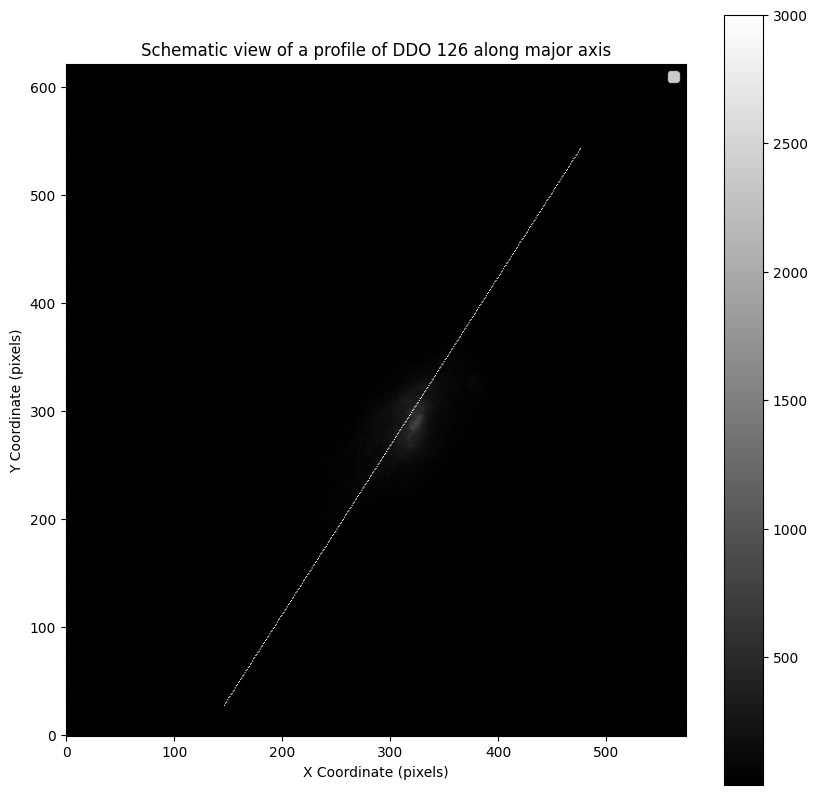

x_ax_left length: 165
x_ax_right length: 165
values_along_line_left length: 165
values_along_line_right length: 165
x_ax combined length: 330
values_along_line combined length: 330


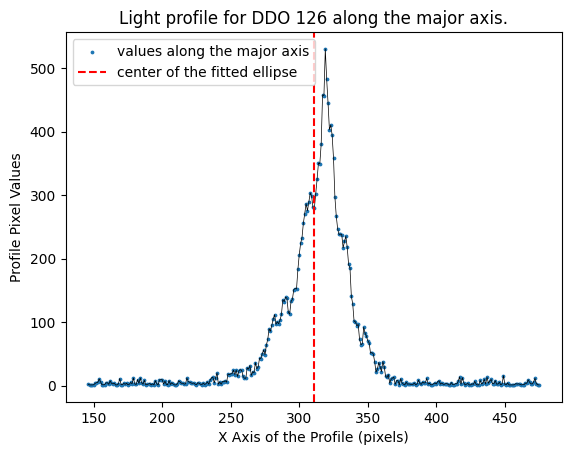

Threshold value: 152.125
Center of galaxy (Equal Area on both sides of the center line): 316


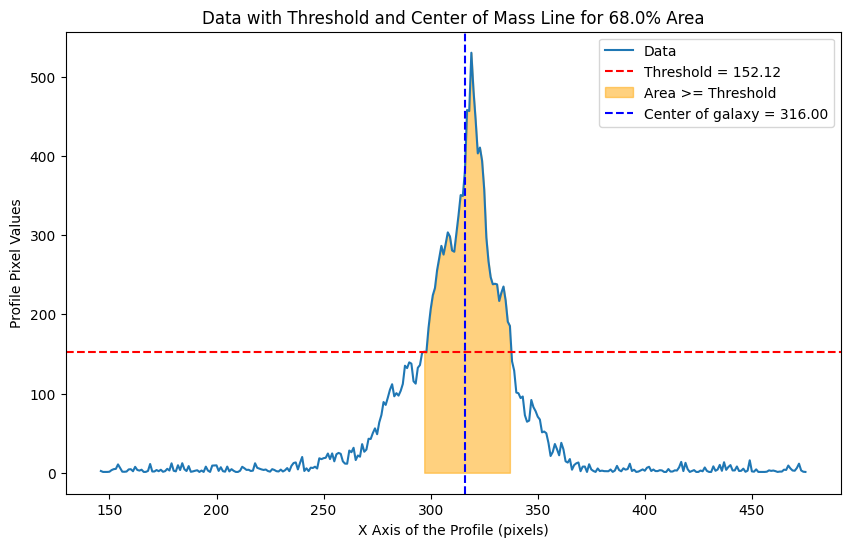

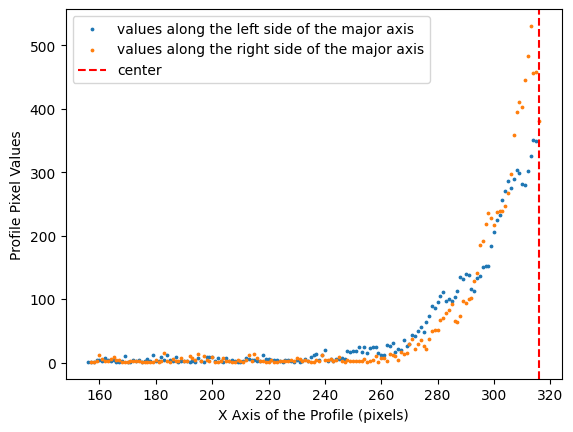

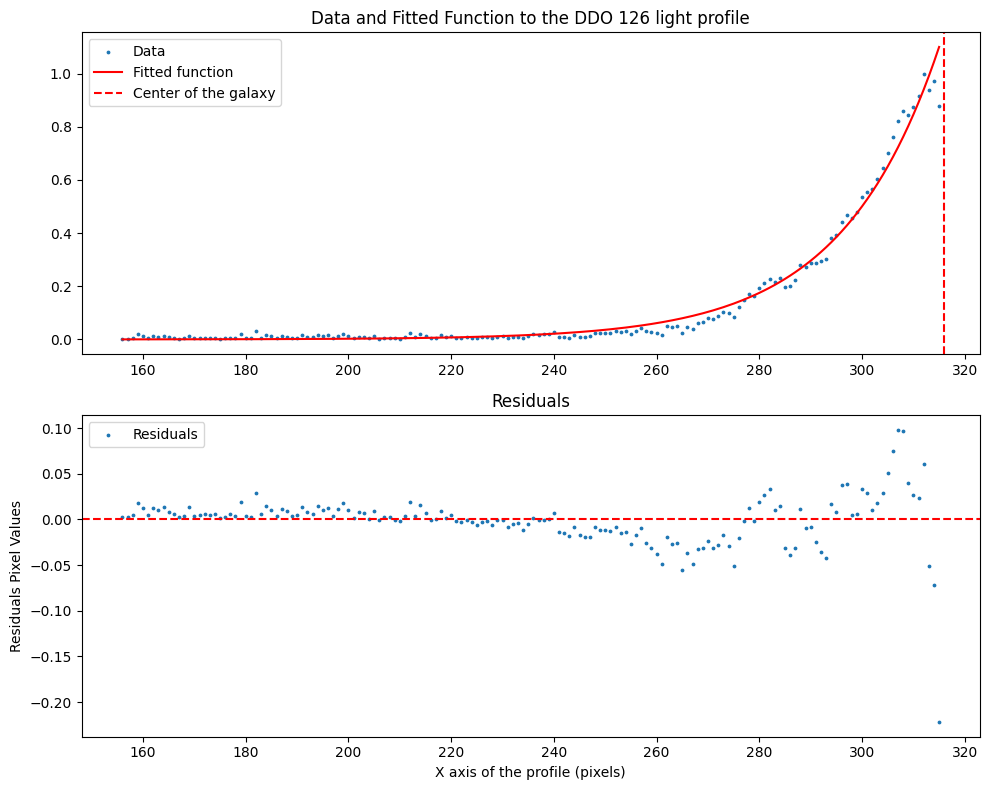

Exponential fit function is a * exp(b * (x - x0)) + c
b is 0.0525 +/- 0.0009
x0 is 313.1848 +/- 0.2043
RD is 19.0546 pixels
RD for DDO 126 is 0.5133140392799815 kpc


In [3]:
galaxy_name = "DDO 126"
D = 4.9
x_start = 150
y_start = 200
a_half = 55
b_half = 32
theta_deg = -32.58 +90
X_center = 311
y_center = 287
n = 3

theta_rad = np.radians(theta_deg)
list_of_ellipse_data = [theta_rad , a_half, b_half]
 
visual_126 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 126\non_shifted_background_d126v.fits"))
visual_126 = visual_126[y_start:y_start + int(2 * X_center), x_start: int(x_start + 2 * y_center)]

x_ax_left = np.arange(X_center - n*a_half, X_center)
x_ax_right = np.arange(X_center, X_center + n*a_half)
x_ax = np.concatenate((x_ax_left, x_ax_right))
theta_rad = np.radians(theta_deg)

def get_line_values(array, X_center, y_center, x_ax, theta_rad): 
        m = np.tan(theta_rad)
        values = [] 
        y_list = [] 
        for x in x_ax: 
            y = int(m * (x) + y_center - m*X_center) 
            values.append(array[y, x]) 
            array[y, x] = 3000 
            y_list.append(y) 
        return values, y_list
def RD(n, image, distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, galaxy_name, ratio=0.68, initial_guesses=[0.006, 25]):
    theta_rad, a, b = list_of_ellipse_data
    
    def get_line_values(array, X_center, y_center, x_ax, theta_rad): 
        m = np.tan(theta_rad)
        values = [] 
        y_list = [] 
        for x in x_ax: 
            y = int(m * (x) + y_center - m*X_center) 
            combined_value = 0.5* float(array[y,x]) + (1/8)*(float(array[y-1,x])+float(array[y+1,x])+float(array[y,x-1])+float(array[y,x+1]))
            values.append(combined_value) 
            y_list.append(y) 
        return values, y_list
        
    center_of_galaxy_x = int(center_of_galaxy_x)
    
    x_ax_left = np.arange(X_center - n*a_half, X_center)
    x_ax_right = np.arange(X_center, X_center + n*a_half)

    values_along_line_left, y_list_left = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y,x_ax_left, theta_rad)
    values_along_line_right, y_list_right = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y,x_ax_right ,theta_rad)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))

    # Add print statements to debug the lengths
    print(f"x_ax_left length: {len(x_ax_left)}")
    print(f"x_ax_right length: {len(x_ax_right)}")
    print(f"values_along_line_left length: {len(values_along_line_left)}")
    print(f"values_along_line_right length: {len(values_along_line_right)}")

    print(f"x_ax combined length: {len(x_ax)}")
    print(f"values_along_line combined length: {len(values_along_line)}")

        
    if len(x_ax) == len(values_along_line):
        plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
        plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
        plt.title(f"Light profile for {galaxy_name} along the major axis.")
        plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
        plt.xlabel("X Axis of the Profile (pixels)")
        plt.ylabel("Profile Pixel Values")
        plt.legend()
        plt.show()
    else:
        print("The lengths of x_ax and values_along_line do not match.")
        print(len(x_ax))
        print(len(values_along_line))
        return
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel("X Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    x_ax_left = x_ax[:com_index]
    x_ax_right = x_ax[com_index:]

    if len(x_ax_left) > len(x_ax_right):
        delete = len(x_ax_left) - len(x_ax_right)
        x_ax_left = x_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(x_ax_left) < len(x_ax_right):
        delete = len(x_ax_right) - len(x_ax_left)
        x_ax_right = x_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    flipped_x_ax_right = []
    for i in range(len(x_ax_right)):
        x = (2 * center_of_mass_x - x_ax_right[i])
        flipped_x_ax_right.append(int(x))

    flipped_x_ax_right = np.array(flipped_x_ax_right)

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='center')
    plt.xlabel("X Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.legend()
    plt.show()
    
    x1 = x_ax_left  
    x2 = flipped_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2)/2
    mean_y_normal = mean_y/np.max(mean_y)
    def exponential_func(x,b,x0):
        return np.exp(b * (x - x0))

    popt, pcov = curve_fit(exponential_func, x_ax_left, mean_y_normal, p0=initial_guesses)

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(x_ax_left, mean_y_normal, s=3, label='Data')
    plt.plot(x_ax_left, exponential_func(x_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y_normal - exponential_func(x_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(x_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('X axis of the profile (pixels)') 
    plt.ylabel('Residuals Pixel Values') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    
    print(f"b is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"x0 is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"RD is {1/popt[0]:.4f} pixels")
    
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((distance * RD_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD_value} kpc")

    return RD_pixels , RD_arcsec, mean_y, x_ax_left

get_line_values(visual_126, X_center, y_center, x_ax, theta_rad)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(visual_126, cmap='gray', origin='lower')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(" ")

plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.legend()
plt.show()

DDO_126 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 126\non_shifted_background_d126v.fits"))
DDO_126 = DDO_126[y_start:y_start + int(2 * X_center), x_start: int(x_start + 2 * y_center)]


RD_pixels , RD_arcsec , y_values , x_values = RD(3, DDO_126, D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name)

sigma is 29.194920666878804
RD values: [0.5463587121216729, 0.49971117676681737, 0.5022182647311856, 0.5259802027053062, 0.5275933621041373, 0.4839274713486942, 0.5185097277224341, 0.5512537792500222, 0.5023195254172449, 0.5350723001341797, 0.527592258730552, 0.5028986312135387, 0.5008360707870575, 0.5358074713911418, 0.5170310767428108, 0.5115593239266677, 0.5075921836349313, 0.4981759998591308, 0.5535041011776335, 0.5436420562643268, 0.5399836739470976, 0.5119929476718132, 0.520673553709764, 0.4903538561355028, 0.4948593703000832, 0.49924750101900817, 0.5274926131949721, 0.4962927457075982, 0.5156525883636205, 0.5209927669735291, 0.5280281574735611, 0.49218426041957786, 0.5162800780625171, 0.5164397417871647, 0.5158141310697923, 0.5152335049768775, 0.48318231441714626, 0.5244754297652513, 0.5304259543097972, 0.5240229119327544, 0.500932108518707, 0.4993771263803392, 0.5138924970673584, 0.5330217125929106, 0.5117035516556078, 0.47848956242615076, 0.5610168273136178, 0.5385143055403724

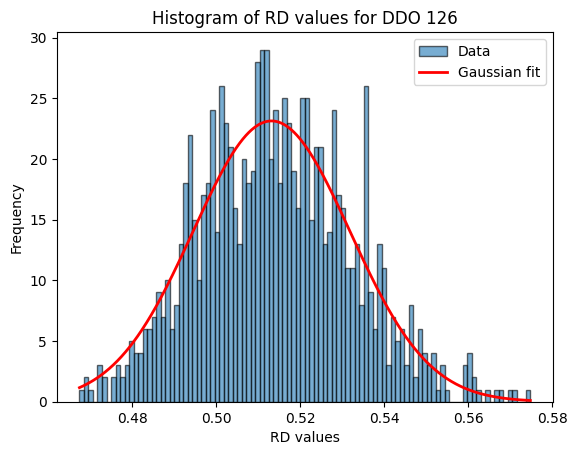

Fitted parameters: A=23.133065310022566, mu=0.5131291027754791, sigma=0.018699995762984294
RD for DDO 126 is 0.513 +/- 0.019


In [4]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Define the exponential function
def exponential_func(x, b, x0):
    return np.exp(b * (x - x0))

# Assume DDO_101 and y_values are defined
sigma = np.std(DDO_126)
print("sigma is" ,sigma)

# Number of iterations
n = 1000

# Lists to store the fitted parameters
b_list = []
x0_list = []
RD_list = []

# Loop for bootstrapping
for i in range(n):
    # Generate unique random noise for each data point from the normal distribution
    noise = np.random.normal(0, sigma, size=len(y_values))
    # Add unique noise to each data point in y_values
    y_noisy = y_values + noise
    y_noisy_normal = y_noisy / np.max(y_noisy)
    # Fit the exponential function to the noisy data
    popt, pcov = curve_fit(exponential_func, x_values, y_noisy_normal, p0=(0.006, 25))
    
    # Append the parameters to the respective lists
    b_list.append(popt[0])
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * 1.134
    RD_value = ((D * RD_arcsec) / 206265)*1000
    RD_list.append(RD_value)
    
    x0_list.append(popt[1])



print(f"RD values: {RD_list}")
# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Generate histogram data
counts, bin_edges = np.histogram(RD_list, bins=100)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guess for the parameters (A, mu, sigma)
initial_guess = [max(counts), np.mean(RD_list), np.std(RD_list)]

# Fit the Gaussian function to the histogram data
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=initial_guess)

# Plot the histogram
plt.hist(RD_list, bins=100, edgecolor='k', alpha=0.6, label='Data')

# Plot the fitted Gaussian curve
x_fit = np.linspace(min(RD_list), max(RD_list), 1000)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Gaussian fit')

# Add labels and title
plt.xlabel('RD values')
plt.ylabel('Frequency')
plt.title(f'Histogram of RD values for {galaxy_name}')
plt.legend()

# Show the plot
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: A={popt[0]}, mu={popt[1]}, sigma={popt[2]}")
rd_value = f"{popt[1]:.3f}" 
rd_error = f"{popt[2]:.3f}"  

print(f"RD for {galaxy_name} is {rd_value} +/- {rd_error}")
